# MODULES

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from sklearn import datasets
from statsmodels.distributions import ECDF

sns.set()


___

# GRAPHICAL EDA

Graphical EDA presents the information in a way that is easily interpretable. It guides the actions to take for hypothesis testing:
+ The greatest value of a picture is that it forces us to notice what we never expected to see.
+ It is important to understand what you can do before you learn how to measure how well you seem to have done it.
+ If done well, graphical representations can allow for more rapid interpretation of data.


> EDA can never be the whole story, but nothing else can serve as the foundation stone.

> \- John Tukey. 


## Continuous Data Visualizations
### Histograms and KDEs

The distribution of sample data can be represented by an histogram; it divides the entire range of values into a series of intervals (or bins), then count how many values fall into each interval. 

An histogram can be normalized to show the proportion of values that fall into each bin, with the sum of the heights equaling 1. This gives a rough assessment of the probability distribution.

But histograms have a few caveats: they depend on the chosen number of bins, their width, and end points. A Kernel Density Estimation (KDE) can be used to smooth the histogram into a curve that approximates the hypothesized PDF; the degree of smoothing depends on the [bandwidth value](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/). 


### Boxplots

Box-plots are a good way to summarize a distribution using its quartiles:

+ IQR with the median inside.
+ whiskers (Tukey boxplot): values within 1.5 IQR of Q1 and Q3.
+ remaining outliers.

They offer a good visual summary when the data is large: they combine graphical EDA with numerical EDA & summary statistics (median, percentiles and outliers). For small datasets, swarm plots are usually enough.


### Empirical Cumulative Distribution Function (ECDF)

The ECDF ([code](https://www.statsmodels.org/stable/_modules/statsmodels/distributions/empirical_distribution.html#ECDF)) shows all the data and gives a complete picture of how the data is distributed. The X-axis represents the quantity you are measuring (petal lenght in the example below), while the Y-axis is the fraction of data points that have a value smaller than the corresponding X-value.

_Note: ECDF also show percentiles, although in a less compact form than boxplots._


### Example

The example below shows several ways of describing the distribution of petal lengths for the iris versicolor sample (50 observations):
+ histograms and KDEs with different binwidth and bandwidth.
+ boxplots & ECDF.

![eda](../../img/eda.png)

___

# NORMAL DISTRIBUTION EXAMPLE - BELMONT STAKES

The data has been scraped from the [Belmont Wikipedia page](https://en.wikipedia.org/wiki/Belmont_Stakes).
+ Secretariat ran the fastest Belmont Stakes in history in 1973. 
+ While that was the fastest year, 1970 was the slowest because of unusually wet and sloppy conditions. 

We remove these two outliers from the data set to compute the mean and standard deviation of the Belmont winners' times. The theoretical CDF and the ECDF of the data suggest that the winning Belmont times are, indeed, normally distributed. This also suggests that in the last 100 years or so, there have not been major technological or training advances that have significantly affected the speed at which horses can run this race.


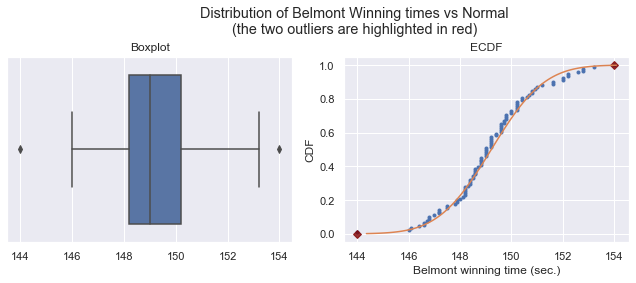

In [27]:
# load df
belmont_df = pd.read_csv('../../data/belmont_stakes.csv')
belmont_no_outliers = belmont_df.loc[belmont_df['IsOutlier'] == 0, 'Time']
belmont_outliers = belmont_df.loc[belmont_df['IsOutlier'] == 1, 'Time'].sort_values()

# ecdf
ecdf_belmont = ECDF(belmont_df['Time'])
x, y = ecdf_belmont.x, ecdf_belmont.y

# Compute mean and standard deviation without the outliers: mu, sigma
mu = belmont_no_outliers.mean()
sigma = belmont_no_outliers.std()
x_theor = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y_theor = stats.norm.cdf(x_theor, mu, sigma)

# Plot the CDFs and show the plot
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (2 * 5, 4))

_ = sns.boxplot(x, ax=ax1)
_ = ax2.plot(x, y, marker='.', linestyle='none')
_ = ax2.plot(belmont_outliers, y[[0, -1]], marker='D', color='maroon', linestyle='none', alpha=0.8)
_ = ax2.plot(x_theor, y_theor)

# labels
_ = ax2.set_xlabel('Belmont winning time (sec.)')
_ = ax2.set_ylabel('CDF')

# titles
_ = ax1.set_title('Boxplot')
_ = ax2.set_title('ECDF')

fig.suptitle('Distribution of Belmont Winning times vs Normal\n(the two outliers are highlighted in red)')

plt.tight_layout(rect=[0, 0, 0.9, 0.9])


If we assume that the Belmont winners' times are Normally distributed (with the 1970 and 1973 years removed), the probability that the winner of a given Belmont Stakes will run it as fast or faster than Secretariat is very small: 0.06%.

_Note: the probability is so low that we need to take a million samples to be sure we get this value from the normal distribution at least once, when using hackers statistics._


In [28]:
secretariat = belmont_df.loc[belmont_df['Winner'] == 'Secretariat', 'Time'].values[0]
prob = stats.norm(mu, sigma).cdf(144)
print('Probability of besting Secretariat: {:.2%}'.format(prob))


Probability of besting Secretariat: 0.06%


___

# BINOMIAL DISTRIBUTION EXAMPLE

A bank made 100 mortgage loans. What is the probabilit of losing money (more than 10% defaults), if the probability of a default is 5%?

We make the assumption that the number of defaults follows a Binomial distribution.


In [29]:
# probability of having exactly 9 defaults (built-in vs manual formula)
print('Proba of having exactly nine defaults, given by the PMF:    {:.5}'.format(stats.binom.pmf(9, 100, 0.05)))
print('Proba of having exactly nine defaults, calculated manually: {:.5}'.format(np.math.factorial(100) / (np.math.factorial(9) * np.math.factorial(100 - 9)) * np.power(0.05, 9) * np.power(1 - 0.05, 100-9)))


Proba of having exactly nine defaults, given by the PMF:    0.034901
Proba of having exactly nine defaults, calculated manually: 0.034901


In [30]:
# Probabilit of losing money (more than 10% defaults)
# p(default >= 10) = 1 - p(defaults <= 9)
print('Probability of losing money = {:.1%}'.format(1 - stats.binom.cdf(9, 100, 0.05)))


Probability of losing money = 2.8%


___

# POISSON DISTRIBUTION EXAMPLE

The number of daily customers of a shop fell from 115 last week to 99 this week. Is this reported change really noteworthy?

We make the assumption that the number of daily customers follows a Poisson distribution:
+ the daily average is constant.
+ the arrival of one customer is independent of the time since the last customer. 

We can check the probability of observing a value at least as extreme as 99 for a Poisson distribution where $\lambda$ is the known daily customer average 115.


Probability of seeing 99 customers per day or less: 7.2%


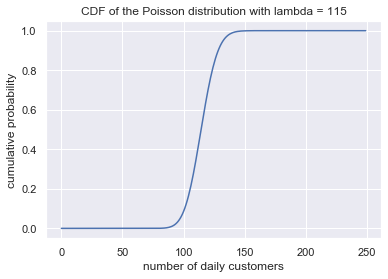

In [31]:
# CDF
_ = plt.plot(range(0, 250), stats.poisson.cdf(range(0, 250), 115))
plt.title('CDF of the Poisson distribution with lambda = 115')
plt.xlabel('number of daily customers')
plt.ylabel('cumulative probability')

# probability of having a number at least at extreme as 99
print('Probability of seeing 99 customers per day or less: {:.1%}'.format(stats.poisson.cdf(99, 115)))
